# Network of Genres

This algorithm aims to perform community detection using Louvain Modularity on different metal music subgenres, based on data obtained by web parsing from Encyclopedia Metallum. Thereafter, we can use the features extracted using dependency parsing to understand these clusters better.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math
import time

The following set of data contains both the raw data from Encyclopedia Metallum, and also processed data which includes features extracted through dependency parsing for each of the review texts. A sample of the data is shown below.

In [2]:
df = pd.read_csv('reviews_full_v9-2.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,...,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep,neg,neu,pos
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,...,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...,0.025,0.826,0.149
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,...,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...,0.038,0.850,0.111
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,...,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...,0.026,0.771,0.202
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,...,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...,0.031,0.723,0.246
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,...,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...,0.130,0.747,0.123


In [43]:
plt.rcParams["figure.figsize"] = (12,10) #defining size of plots

In [5]:
G = nx.Graph()
B = nx.Graph()

Firstly, a bipartite graph is constructed between genres and users, where an edge represents that a genre has been reviewed by a particular user. We also set a positive score threshold to be 75 as we define a positive review score to be more than or equal to 75.

In [6]:
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    album = row['Release'] + 'A'
    users.add(user)
    for genre in genre_list:
        genres.add(genre)
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
            #B[user][genre]['concepts'].add((album,user))
        else:
            B.add_edge(user, genre, weight = 1)
            #B.add_edge(user, genre, weight = 1, concepts = {(album,user)})

In [7]:
B.number_of_nodes(), B.number_of_edges()

(8344, 33217)

The following set of code identifies and removes the supernodes which are structural holes. This is because of the observation that these supernodes can dilute the edges and make clustering more difficult.

[131, 125, 84, 82, 82, 81, 77, 75, 72, 72, 70, 67, 66, 64, 63, 62, 62, 61, 61, 60, 58, 55, 55, 54, 54, 54, 53, 53, 51, 51]


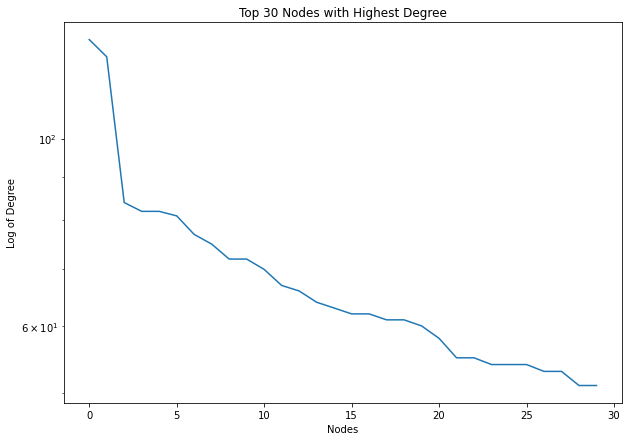

In [8]:
plt.title('Top 30 Nodes with Highest Degree')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
tmp = sorted([B.degree[user] for user in users])[-30:]
tmp.reverse()
plt.semilogy(tmp)
print(tmp)
plt.show()

In [9]:
#removing structural holes
remove_users = set()
for user in users.copy():
    if B.degree[user] > 100:
        B.remove_node(user)
        print(user)
        remove_users.add(user)
        users.remove(user)

hells_unicorn
autothrall


Then we proceed to create the Network of Genres, where two genres share an edge if they have both been reviewed by a similar user. The edge weight is defined as the number of similar users.

In [10]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        for genre2 in B.adj[user]:
            if genre2 >= genre1:
                continue
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += 1
                #G[genre1][genre2]['concepts'] = G[genre1][genre2]['concepts'].union(B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))
                #G[genre1][genre2]['users'].add(user)
            else:
                G.add_edge(genre1, genre2, weight = 1)
                #G.add_edge(genre1, genre2, weight = 1, concepts = B[genre1][user]['concepts'].union(B[genre2][user]['concepts']))

In [11]:
G.number_of_nodes(), G.number_of_edges()

(289, 18130)

In [16]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    #if node not in genre_group:
        #print(node)
    if node not in genre_group:
        pass
    elif  genre_group[node] == 'Non-metal' or genre_group[node] == 'Others': #only consider metal genres
        G.remove_node(node)
print(G.number_of_nodes())

289
190


In [17]:
G3 = G.copy()

Thereafter, we perform the K-Core algorithm to remove unimportant genres to reduce noise in the network.

In [18]:
K = G3.copy()
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K)
sortbylen = lambda cc : len(cc)
Core = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])
#nx.draw(Core, node_size = 20)

In [19]:
Core.number_of_nodes(),Core.number_of_edges()

(109, 5649)

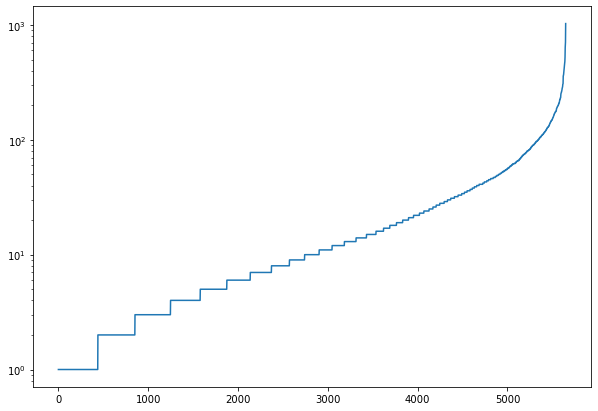

In [20]:
plt.semilogy(sorted(list(nx.get_edge_attributes(Core,'weight').values())))
plt.show()

In [24]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

The Louvain Method for Community Detection is not exact as exact modularity optimization would be NP-Hard. (Blondel, 2011) Hence there is a need to an average partitioning of the genres based on a probabilistic method, to obtain accurate and stable clusters. 
The network is partitioned using the Community Detection Algorithm for 100 times, which is more than sufficient to create an accurate average network of genres. This new average network of genres is created with the same nodes (i.e. genres) but the edge weights are now computed such that the weight of an edge between Genre A and Genre B is the probability that Genre A and Genre B fall in the same cluster during the 100 repeated partitioning earlier. This new Probability Network of Genres undergoes another round of 100 times of partitioning. This process repeats itself until the probabilities (edge weights) converge to 1, when maximum certainty is obtained, and the resultant average Network of Genres would be obtained, where all inter-cluster edges would be removed. 

Below shows the code to obtain average partitionings. the Joblib library is used to perform parallel computation for more efficient runtime.

In [25]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight', res = 1):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = res) for i in range(n_iter))
    
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [26]:
#H = G.copy()
H = Core.copy()
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 2)

1 5886 5649
1 5886 3902
1 5886 3902
3 2408 2408


In [27]:
partitions = [cc for cc in nx.connected_components(H)]

In [28]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [Core.subgraph(comp) for comp in comps]
    ave_weight = [sum([Core[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    ave_cluster_weight = [sum([Core[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    density = [sub.number_of_edges()/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for sub in subgraphs]
    std_dev = [np.std([Core[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    #ave_coeff = [nx.average_clustering(Core, nodes = sub.nodes(), weight = 'weight') for sub in subgraphs]
    ave_coeff = [nx.average_clustering(sub, weight = 'weight') for sub in subgraphs]
    #ave_weight1 = [np.mean([G[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    return ave_weight, ave_cluster_weight, density, std_dev, ave_coeff

In [29]:
[len(cc) for cc in partitions]

[48, 11, 50]

In [30]:
cluster = Core.subgraph(list(nx.connected_components(H))[0])
#nx.draw(cluster, node_size = 100,  font_size = 12, edge_color = 'black', width = np.array([Core[u][v]['weight'] for u,v in cluster.edges()])*0.01)
#plt.show()

In [31]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'], ret['Average_Weight_by_Nodes'], ret['Cluster_Density'], ret['Std_Dev'], ret['Average_Clustering_Coefficient'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
data = genData(H,1)
data

,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{extreme folk metal, progressive metalcore, pr...",48,25.234534,24.227837,0.960106,54.810346,0.023615
1,"{metalcore, progressive death metal, black met...",11,112.872727,112.872727,1.000000,165.630701,0.079107
2,"{extreme avantgarde metal, celtic folk metal, ...",50,22.050707,21.654694,0.982041,29.144492,0.066756


In [32]:
clusters = []
inp = input('Enter Cluster ID to Keep: ')
if inp != 'None':
    for x in inp.split():
        clusters.append(G.subgraph(list(nx.connected_components(H))[int(x)]))

Enter Cluster ID to Keep:  1


Further breakdown of large clusters:

In [33]:
from IPython.display import display, HTML
def breakDown(inds):
    for ind in inds:
        G1 = Core.subgraph(list(nx.connected_components(H))[ind])
        while not no_crossedges(G1):
            G1 = freq_network_parr(G1, 100, 2)
        print('End Clustering: ',ind)
        display(genData(G1,'2-'+ str(ind)))
        inp1 = input('Clusters to keep')
        inp2 = input('Clusters to breakdown')
        keep = {}
        brk = {}
        if inp1 != 'None':
            keep = {int(x) for x in inp1.split(' ')}
        if inp2 != 'None':
            brk = {int(x) for x in inp2.split(' ')}
        for i,comp in enumerate(nx.connected_components(G1)):
            if i in keep:
                clusters.append(Core.subgraph(comp))
            elif i in brk:
                G2 = Core.subgraph(comp)
                while not no_crossedges(G2):
                    G2 = freq_network_parr(G2, 100, 2)
                print('End Clustering: ',i)
                display(genData(G2,'3-'+ str(i)))
                for cc in nx.connected_components(G2):
                    clusters.append(Core.subgraph(cc))

In [34]:
inp = 0
tmp = []
inp = input('Enter Cluster IDs for Breakdown: ')
breakDown([int(x) for x in inp.split()])

Enter Cluster IDs for Breakdown:  0 2


1 1128 1083
1 1128 963
1 1128 963
2 561 561
End Clustering:  0


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{melodic thrash metal, bay area thrash metal, ...",27,9.924925,9.415954,0.948718,12.105284,0.114423
1,"{extreme folk metal, progressive metalcore, pr...",21,60.908213,60.038095,0.985714,106.320345,0.058792


Clusters to keep None
Clusters to breakdown 0 1


1 351 333
1 351 239
1 351 239
3 115 115
End Clustering:  0


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{progressive sludge metal, melodic progressive...",6,9.642857,9.000000,0.933333,16.038379,0.090061
1,"{groove metal, alternative thrash metal, neocl...",10,8.418605,8.044444,0.955556,11.200566,0.118242
2,"{melodic thrash metal, new wave of british hea...",11,15.388889,15.109091,0.981818,14.495742,0.195477


1 210 207
1 210 150
1 210 150
2 112 112
End Clustering:  1


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{symphonic gothic metal, extreme folk metal, m...",14,12.886364,12.461538,0.967033,13.654363,0.160350
1,"{symphonic power metal, progressive metal, mel...",7,308.333333,308.333333,1.000000,168.939925,0.404364


1 1225 1203
1 1225 878
1 1225 878
4 398 398
End Clustering:  2


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{extreme avantgarde metal, avantgarde black me...",25,19.789831,19.460000,0.983333,23.567499,0.105773
1,"{death doom metal, gothic doom metal, melodic ...",6,24.000000,24.000000,1.000000,30.086542,0.168902
2,"{drone doom metal, sludge metal, psychedelic d...",11,35.727273,35.727273,1.000000,55.010893,0.096545
3,"{atmospheric black metal, neofolk, experimenta...",8,38.714286,38.714286,1.000000,30.775520,0.234558


Clusters to keep 1 2 3
Clusters to breakdown 0


1 300 295
1 300 229
1 300 229
3 98 98
End Clustering:  0


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{industrial black metal, psychedelic black met...",11,21.818182,21.818182,1.0,24.732085,0.149548
1,"{melodic black metal, folk metal, celtic folk ...",8,30.107143,30.107143,1.0,29.128213,0.170319
2,"{symphonic death metal, blackened thrash metal...",6,13.666667,13.666667,1.0,14.704497,0.173268


In [35]:
#nx.write_gpickle(Core,'network_genres.p')

In [36]:
cluster_id = {}
for i,cluster in enumerate(clusters):
    for genre in cluster.nodes():
        cluster_id[genre] = i

In [37]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer() 
def isNaN(x):
    return x != x

def lem(x):
    return ' '.join([lemma.lemmatize(word) for word in x.split()])

In [38]:
t1 = time.time()
all_features = [{} for i in range(len(clusters))]

for i,row in df.iterrows():
    if isNaN(row['Combined_Genre']) or isNaN(row['Product Features_dep']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    if i%5000 == 0:
        print(i,time.time()-t1)
    feature_list = [lem(feature) for feature in row['Product Features_dep'].split('|') if 'metal' not in feature]
    cluster_ids = set([cluster_id[genre] for genre in genre_list if genre in cluster_id])
    for clus in cluster_ids:
        for phrase in feature_list:
            if phrase in all_features[clus]:
                all_features[clus][phrase] += 1
            else:
                all_features[clus][phrase] = 1

0 0.1406536102294922
5000 2.895062208175659
20000 7.011021614074707
25000 8.412306785583496
30000 9.80159044265747
35000 11.29591679573059
40000 13.15394639968872
45000 14.863430500030518
50000 16.924859046936035
55000 18.88329005241394
60000 21.499774932861328
65000 23.50241708755493
70000 25.520018339157104
75000 27.351120948791504
85000 32.414576053619385


In [39]:
import pickle

pickle.dump(all_features,open('all_features_by_cluster.p','wb'))

0 0.15059661865234375
10000 2.4285049438476562
20000 4.836064100265503
30000 6.899543762207031
40000 10.10429835319519
50000 14.530722618103027
60000 17.377224922180176
70000 20.180622339248657
80000 22.973725080490112
90000 25.636497020721436


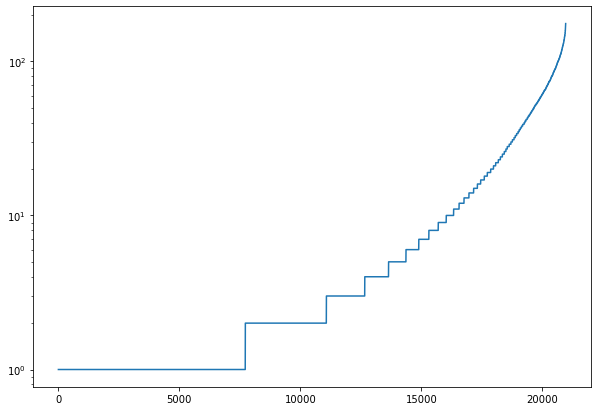

In [40]:
def isNaN(x):
    return x != x

adj_to_genre = {}
t1 = time.time()
all_genres = set()
for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    features = row['Product Features_dep'].split('|')
    genres = row['Combined_Genre'].split('|')
    album = row['Release']
    for genre in genres.copy():
        if genre not in genre_group or genre_group[genre] == 'Non-metal' or genre_group[genre] == 'Others':
            genres.remove(genre)
    
    for feature in features:
        adj = lemma.lemmatize(feature.split(' ')[0])
        if adj not in adj_to_genre:
            adj_to_genre[adj] = set()
        for genre in genres:
            adj_to_genre[adj].add(genre)
            all_genres.add(genre)

genfreq = {}
for adj in adj_to_genre:
    if len(adj_to_genre[adj]) != 0:
        genfreq[adj] = len(adj_to_genre[adj])

plt.semilogy(sorted(genfreq.values()))
plt.show()    

In [41]:
#cxt is term frequency (tf)
idf = {}
for adj in genfreq:
    idf[adj] = math.log(len(all_genres)/genfreq[adj])

tfidf_list = []

for i, tf in enumerate(all_features):
    tfidf = {}
    for feature in tf:
        adj = feature.split(' ')[0]
        tfidf[feature] = tf[feature]*idf[adj]
    tfidf_list.append(tfidf)

Top 50 features for each cluster


112.87272727272727
['metalcore', 'progressive death metal', 'black metal', 'deathcore', 'brutal death metal', 'progressive deathcore', 'death metal', 'technical death metal', 'grindcore', 'technical deathcore', 'industrial grindcore']
['double bass', 'old school', 'swedish band', 'previous album', 'guttural vocal', 'clean vocal', 'sound quality', 'rhythm guitar', 'entire album', 'low end', 'acoustic guitar', '21st century', 'harsh vocal', 'norwegian band', 'catchy riff', 'little bit', 'french band', 'subject matter', 'serial killer', 'lyrical theme', 'brutal band', 'final track', 'bad thing', 'long time', 'female vocal', 'norwegian scene', 'lead guitar', 'black band', 'main riff', 'guttural growl', 'young band', 'fast riff', 'polish band', 'early 90', 'lyrical content', 'late 80', 'raw sound', 'sub genre', 'finnish band', 'spoken word', 'favorite track', 'american band', 'best song', 'distorted guitar', 'past year', 'dark atmosphere', 'raw production'

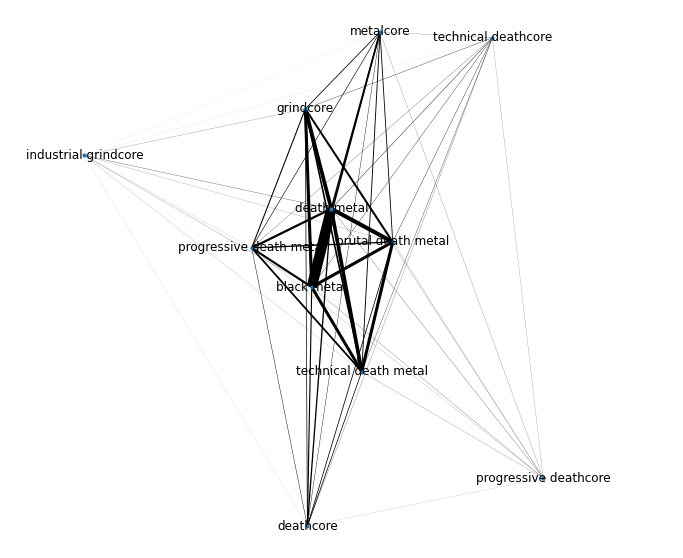


9.642857142857142
['progressive sludge metal', 'progressive thrash metal', 'technical thrash metal', 'oriental folk metal', 'melodic progressive metal', 'progressive stoner metal']
['overactive imagination', 'meshuggah fan', 'late 80', 'previous album', 'clean vocal', 'pendulous skin', 'technical thrash', 'meshuggah album', 'stall speed', 'double bass', 'entire album', 'rhythm section', 'tech thrash', 'classical music', 'progressive thrash', 'best song', 'best album', 'outer isolation', 'fast riff', 'live album', 'flatline drivel', 'underrated band', 'thrash riff', 'odd time', '21st century', 'later album', 'progressive band', 'favorite song', 'fourth album', 'progressive element', 'middle section', 'favorite track', 'favorite album', 'vehicular homicide', 'hairier personality', 'main riff', 'longer song', 'young band', 'waltari album', 'untrained ear', 'female vocal', 'copious amount', 'secret face', 'lead guitar', 'later work', 'american band', 'thrash band', 'progressive album', 's

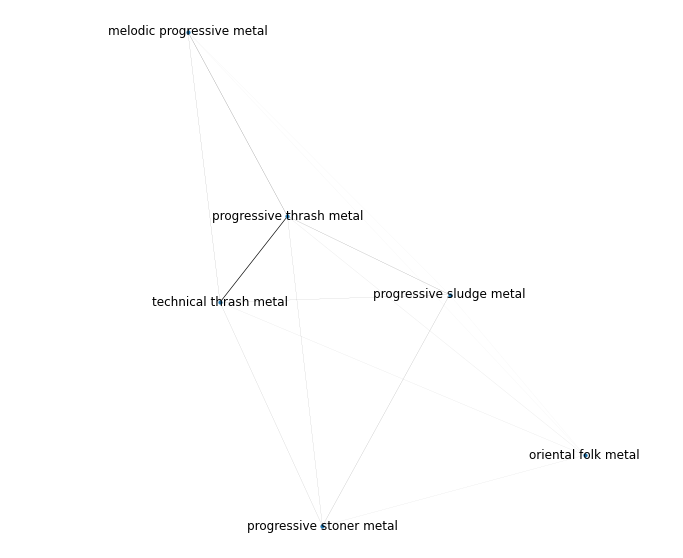


8.418604651162791
['groove metal', 'alternative thrash metal', 'neoclassical heavy metal', 'progressive folk metal', 'extreme industrial metal', 'industrial metal', 'progressive rock', 'industrial thrash metal', 'industrial progressive metal', 'groove thrash metal']
['previous album', 'tough guy', 'clean vocal', 'double bass', 'hard rock', 'main riff', 'best song', 'electric guitar', 'entire album', 'harsh vocal', 'live album', 'acoustic guitar', 'rhythm section', 'progressive rock', 'skip button', 'favorite song', 'best album', 'female vocal', 'bad thing', 'long time', 'lyrical theme', 'industrial music', 'little bit', 'open mind', 'industrial element', 'groovy riff', 'prog rock', 'progressive music', 'mixed bag', 'new album', '11th hour', '21st century', 'half thrash', 'earlier work', 'thrash riff', 'later album', 'heavy riff', 'worst song', 'focal point', 'rhythm guitar', 'served cold', 'past year', 'good song', 'previous release', 'shorter song', 'decent song', 'catchy riff', 'wor

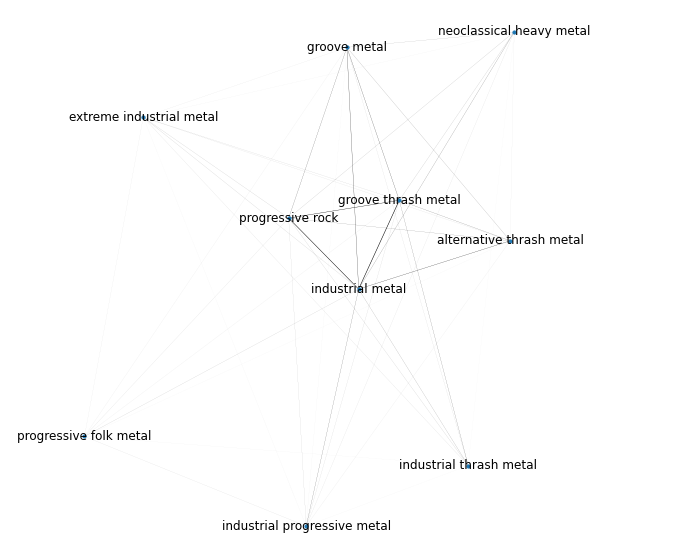


15.38888888888889
['melodic thrash metal', 'new wave of british heavy metal', 'us industrial metal', 'bay area thrash metal', 'teutonic thrash metal', 'electro industrial metal', 'first wave of black metal', 'crossover thrash metal', 'epic doom metal', 'gothic black metal', 'neoclassical power metal']
['main riff', 'previous album', 'best song', '21st century', 'live album', 'thrash album', 'subject matter', 'double bass', 'rhythm guitar', 'best album', 'hard rock', 'dissatisfied existence', 'lead guitar', 'fastest song', 'middle section', 'old school', 'catchy chorus', 'catchy riff', 'acoustic guitar', 'late 80', 'fast riff', 'entire album', 'little bit', 'pain album', 'german band', 'lyrical content', 'personal favorite', 'thrash riff', 'humble opinion', 'greatest album', 'instant classic', 'long time', 'classic album', 'thrash scene', 'lyrical theme', 'vocal performance', 'fast song', 'skip button', 'longest song', 'awesome riff', 'bad thing', 'rhythm section', 'thrash fan', 'sound

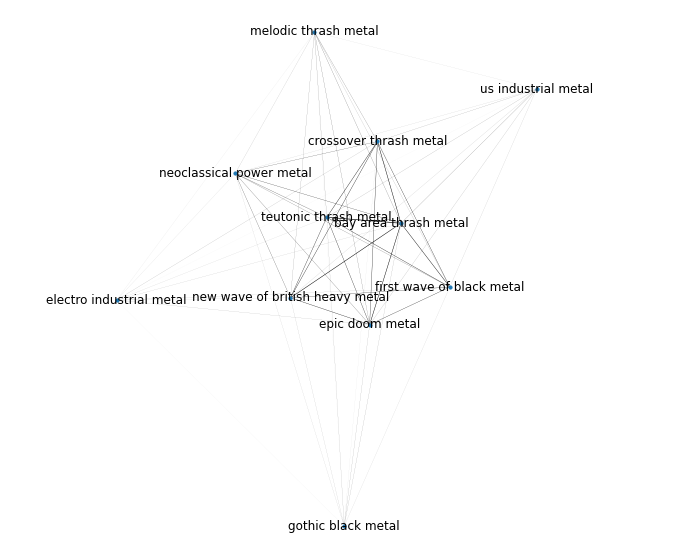


12.886363636363637
['symphonic gothic metal', 'extreme folk metal', 'melodic power metal', 'djent', 'progressive metalcore', 'melodic metalcore', 'extreme power metal', 'symphonic metal', 'extreme gothic metal', 'symphonic progressive metal', 'gothenburg metal', 'progressive heavy metal', 'progressive math metal', 'progressive power metal']
['female vocal', 'harsh vocal', 'clean vocal', 'previous album', 'male vocal', 'double bass', 'operatic vocal', 'symphonic band', 'symphonic element', 'female vocalist', 'entire album', 'best song', 'rhythm guitar', 'acoustic guitar', 'rhythm section', 'little bit', 'gothic band', 'bad thing', 'finnish band', 'classical music', 'favorite song', 'catchy chorus', 'nightwish fan', 'hard rock', 'best album', 'favorite track', 'long time', 'subject matter', 'female singer', 'new album', '13th floor', 'latest album', 'dutch band', 'favorite album', 'past year', 'nightwish album', 'catchy riff', 'lyrical theme', 'single song', 'focal point', 'main riff', 

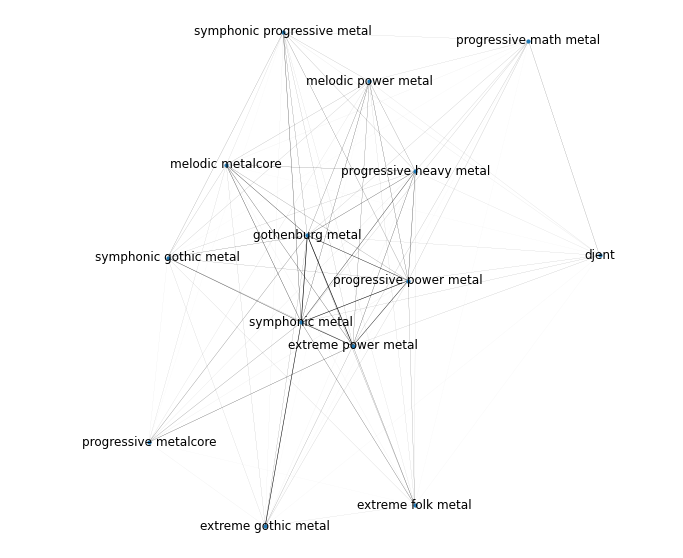


308.3333333333333
['symphonic power metal', 'progressive metal', 'power metal', 'melodic death metal', 'us power metal', 'heavy metal', 'thrash metal']
['previous album', 'double bass', 'hard rock', 'best song', 'late 80', 'main riff', 'old school', 'subject matter', 'little bit', 'entire album', 'catchy chorus', 'acoustic guitar', 'live album', '21st century', 'rhythm guitar', 'rhythm section', 'female vocal', 'favorite song', 'catchy riff', 'harsh vocal', 'long time', 'vocal performance', 'german band', 'best album', 'blind guardian', 'bad thing', 'clean vocal', 'young band', 'lyrical theme', 'lead guitar', 'fastest song', 'fast song', 'past year', 'lyrical content', 'favorite track', 'fast riff', 'late 90', 'swedish band', 'heavy riff', 'high note', 'new album', 'vocal line', 'bad song', 'sound quality', 'final track', 'solid album', 'second album', 'later album', 'prime example', 'thrash riff']


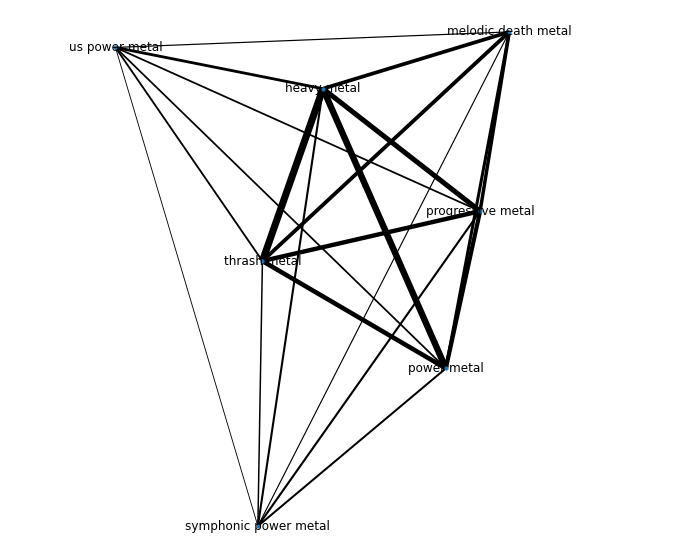


21.818181818181817
['extreme avantgarde metal', 'psychedelic black metal', 'symphonic black metal', 'avantgarde black metal', 'extreme progressive metal', 'avantgarde metal', 'gothic rock', 'instrumental post-metal', 'progressive black metal', 'industrial black metal', 'gothic metal']
['female vocal', 'clean vocal', 'avant garde', 'harsh vocal', 'gothic band', 'male vocal', 'operatic vocal', 'acoustic guitar', 'previous album', 'double bass', 'female vocalist', 'spoken word', 'norwegian band', 'symphonic band', 'electric guitar', 'entire album', 'sound effect', 'symphonic element', 'long time', 'favorite track', 'later album', 'favorite song', 'best song', 'little bit', 'norwegian scene', 'classical music', 'bad thing', 'final track', 'lyrical theme', 'best album', 'lead guitar', '21st century', 'catchy riff', 'earlier work', 'italian band', 'distorted guitar', 'latest album', 'epitome viii', 'later work', 'lyrical content', 'tyrant demo', 'earlier album', 'rhythm section', 'black ban

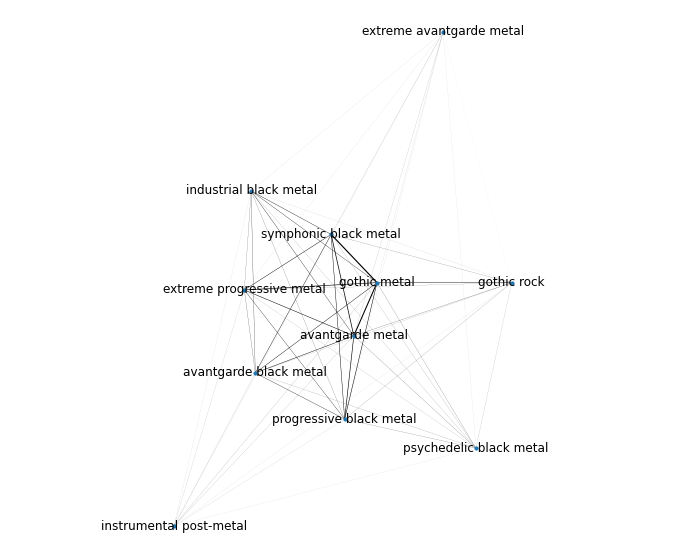


30.107142857142858
['melodic black metal', 'folk metal', 'celtic folk metal', 'blackened heavy metal', 'viking folk metal', 'pagan folk metal', 'pagan black metal', 'viking black metal']
['acoustic guitar', 'harsh vocal', 'female vocal', 'clean vocal', 'norse mythology', 'electric guitar', 'male vocal', 'double bass', 'previous album', 'pagan band', 'norwegian band', 'celtic music', 'entire album', 'best song', 'celtic folk', 'little bit', 'subject matter', 'folkish melody', 'bad thing', 'finnish band', 'lyrical theme', 'rhythm guitar', 'swedish band', 'female vocalist', 'long time', 'favorite song', 'traditional instrument', 'norwegian scene', 'native tongue', 'distorted guitar', 'acoustic passage', 'epic song', 'lead guitar', 'faroese lyric', 'best album', 'young band', 'growled vocal', 'german band', 'final track', 'lyrical content', 'celtic melody', 'celtic influence', 'catchy riff', 'native language', 'previous release', 'instrumental track', 'sound quality', 'black band', 'sub g

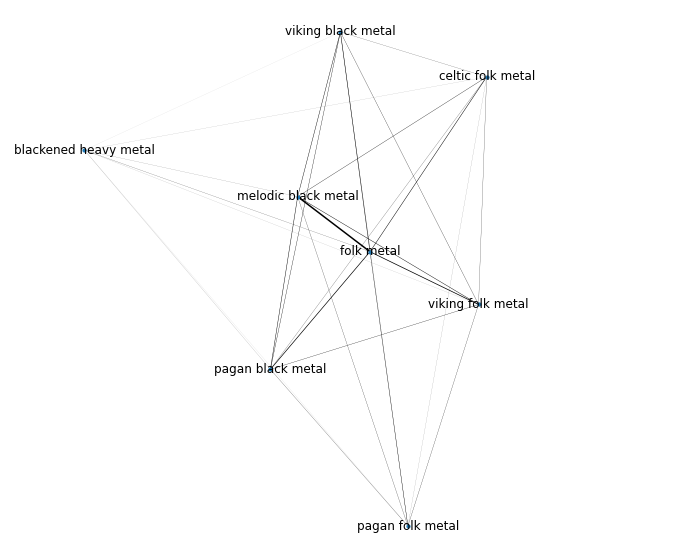


13.666666666666666
['symphonic death metal', 'blackened thrash metal', 'industrial death metal', 'atmospheric death metal', 'experimental death metal', 'blackened death metal']
['double bass', 'black death', 'canadian band', 'behemoth fan', 'female vocal', 'old school', 'previous album', '21st century', 'black thrash', 'clean vocal', 'harsh vocal', 'entire album', 'teutonic thrash', 'thrash riff', 'little bit', 'guttural vocal', 'portal album', 'long time', 'main riff', 'hyrdocianic darkness', 'lovecraftian theme', 'final track', 'polish band', 'rehearsal room', 'young band', 'deep growl', 'far cry', 'subject matter', 'memorable riff', 'bad thing', 'acoustic guitar', 'prime example', 'low end', 'nocturnus member', 'supplant god', 'brutal band', 'dark atmosphere', 'favorite song', 'lyrical content', 'italian band', 'humble opinion', 'previous release', 'storming evil', 'favourite track', 'rhythm guitar', 'longest track', 'earlier album', 'brute force', 'best album', 'extreme band']


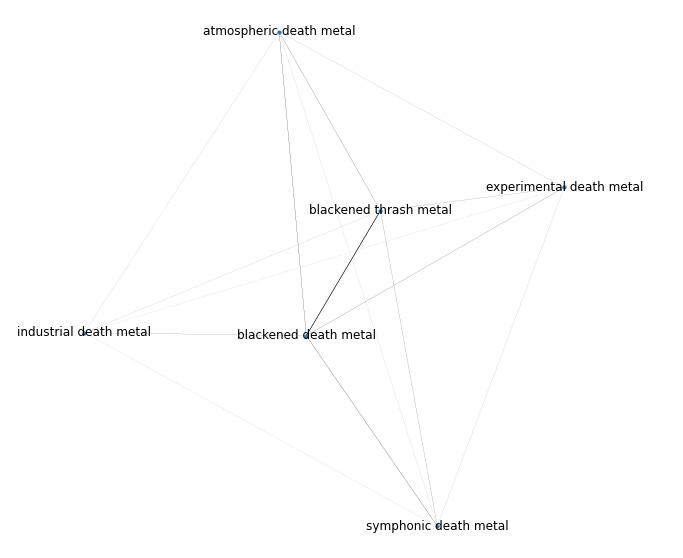


24.0
['death doom metal', 'gothic doom metal', 'melodic doom metal', 'atmospheric doom metal', 'folk doom metal', 'atmospheric gothic metal']
['female vocal', 'clean vocal', 'discouraged one', 'funeral doom', 'chompy riff', 'harsh vocal', 'southeastern scene', 'male vocal', 'acoustic guitar', 'sassy attitude', 'flippy percussion', 'growled vocal', 'gothic band', 'spoken word', 'spiffy logo', 'finnish band', 'gothic doom', 'female vocalist', 'transylvanian forest', 'lead guitar', 'deep growl', 'previous album', 'rhythm guitar', 'slow riff', 'double bass', 'old school', 'best song', 'ragged vocal', 'guttural vocal', 'distorted guitar', 'swedish band', 'gloomy atmosphere', 'prophetic throne', 'heavy riff', 'entire album', 'enforced melody', 'genital masturbation', 'longer song', 'sunny day', 'angelic voice', 'stark contrast', 'main riff', 'clean guitar', 'electric guitar', 'spoken vocal', 'dutch band', 'deathless king', 'young band', 'draconian album', 'bad thing']


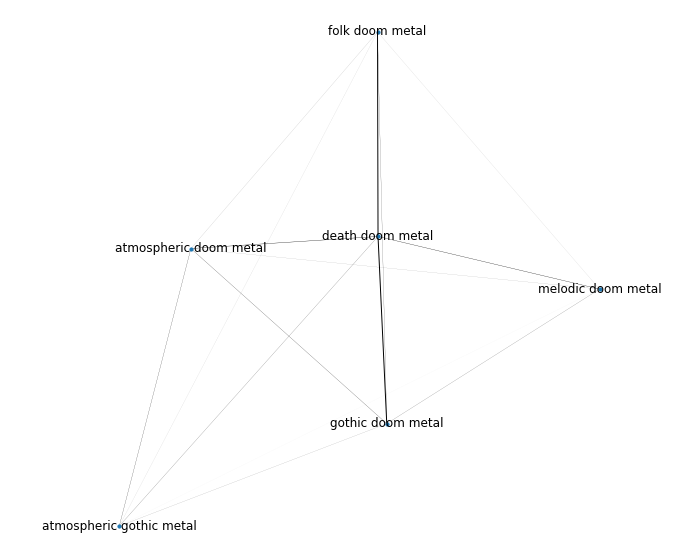


35.72727272727273
['drone doom metal', 'sludge metal', 'psychedelic doom metal', 'stoner metal', 'blackened sludge metal', 'ambient doom metal', 'stoner rock', 'psychedelic stoner metal', 'blackened doom metal', 'funeral doom metal', 'doom metal']
['funeral doom', 'female vocal', 'funeral band', 'clean vocal', 'acoustic guitar', 'lead guitar', 'serial killer', 'distorted guitar', 'harsh vocal', 'wounded king', 'subject matter', 'main riff', 'slow riff', 'long time', 'low end', 'heavy riff', 'previous album', 'little bit', 'rhythm guitar', 'sub genre', 'lyrical theme', 'entire album', 'final track', 'southern rock', 'rhythm section', 'sludgy riff', 'favorite track', 'sabbathian riff', 'double bass', 'bad thing', 'best song', 'hard rock', 'long song', 'second track', 'psychedelic rock', 'shorter song', 'old school', 'focal point', 'fuzzy guitar', 'funeral album', 'guttural vocal', 'lyrical content', 'spoken word', 'traditional doom', 'tortured scream', 'overall sound', 'second album', '

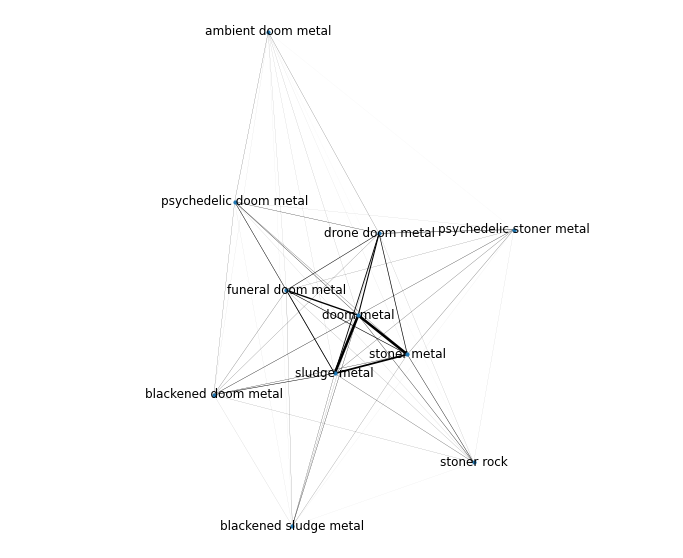


38.714285714285715
['atmospheric black metal', 'neofolk', 'experimental black metal', 'post-metal', 'ambient black metal', 'atmospheric sludge metal', 'shoegaze', 'depressive black metal']
['acoustic guitar', 'female vocal', 'clean vocal', 'depressive band', 'harsh vocal', 'distorted guitar', 'electric guitar', 'previous album', 'spoken word', 'ambient music', 'rock influence', 'sub genre', 'ambient track', 'double bass', 'final track', 'subject matter', 'sole member', 'black band', 'entire album', 'neo folk', 'favorite track', 'tortured vocal', 'urban blue', 'american band', 'lead guitar', 'cascadian scene', 'rock band', 'split album', 'bad thing', 'black album', 'long time', 'acoustic passage', 'ambient piece', 'cold atmosphere', 'ambient section', 'clean guitar', 'rock element', 'lyrical theme', 'bleak atmosphere', 'previous release', 'sound quality', 'long song', 'little bit', 'depressive atmosphere', 'depressive album', 'programmed drum', 'past year', 'overall sound', 'best song'

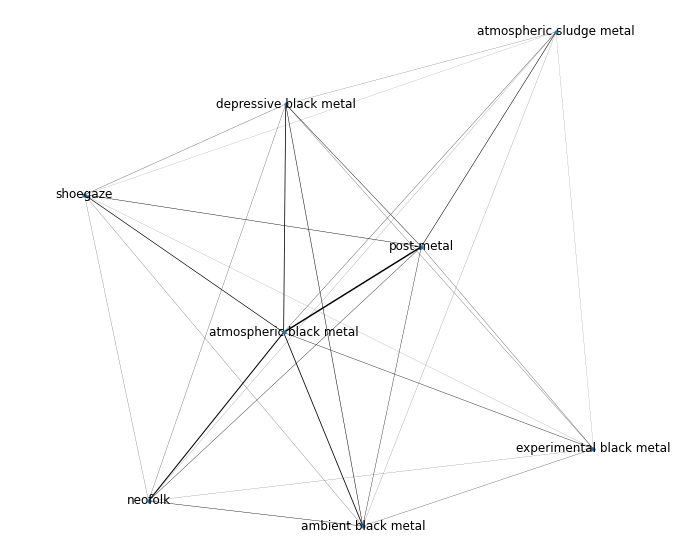

In [67]:
data = pd.DataFrame()
clus_features = []
clus_nodes = []
print('Top 50 features for each cluster\n\n')
for i,cluster in enumerate(clusters):
    pos = nx.spring_layout(cluster)
    l,r = plt.xlim()
    nx.draw(cluster, node_size = 10, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])*0.01)
    print(np.mean(np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])))
    mp = {k: v for k, v in sorted(tfidf_list[i].items(), key=lambda item: item[1], reverse = True)}
    print(cluster.nodes())
    print(list(mp.keys())[:50])
    clus_nodes.append(','.join(cluster.nodes()))
    clus_features.append(','.join(list(mp.keys())[:50]))
    plt.xlim(-1.3,1.3)
    plt.savefig('Cluster ' + str(i) +'.png')
    plt.show()
    print()


data['Genres'] = clus_nodes
data['Features'] = clus_features
data['Cluster Size'] = [cluster.number_of_nodes() for cluster in clusters]
data.to_csv('genre_network_results.csv')